In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE



In [3]:
data = pd.read_csv('/kaggle/input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')
data.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [4]:
print(data.isna().sum())
print("\n")
print("Total missing Values ",data.isna().sum().sum())

no.                       0
sex                       0
age                       0
eeg.date                  0
education                15
                         ..
COH.F.gamma.p.P4.r.O1     0
COH.F.gamma.p.P4.s.O2     0
COH.F.gamma.q.T6.r.O1     0
COH.F.gamma.q.T6.s.O2     0
COH.F.gamma.r.O1.s.O2     0
Length: 1149, dtype: int64


Total missing Values  973


In [5]:
missing_values=data.isna().sum()
print("Missing Values in \n",missing_values[missing_values > 0])

Missing Values in 
 education        15
IQ               13
Unnamed: 122    945
dtype: int64


In [6]:
new_data=data.drop(columns=["education","IQ","Unnamed: 122","no.","sex","age","eeg.date","specific.disorder"])

In [7]:
new_data.head()

,main.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,Addictive disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,Addictive disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,Addictive disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,Addictive disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,Addictive disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [8]:
print("Each class count:")
print(new_data['main.disorder'].value_counts())

Each class count:
main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64


In [9]:


PSD = [col for col in new_data.columns if col.startswith("AB")]

scaler = StandardScaler()
X = new_data[PSD].values
X_scaled = scaler.fit_transform(X)

y = new_data['main.disorder']
y_encoded = LabelEncoder().fit_transform(y)


In [10]:
unique_classes = np.unique(y_encoded)
sampling_strategy = {label: 500 for label in unique_classes}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_encoded)

balanced_data = pd.DataFrame(X_balanced, columns=PSD)
balanced_data['main.disorder'] = y_balanced
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)



In [11]:
X_new = balanced_data.drop(columns=['main.disorder']).values
y_new = balanced_data['main.disorder'].values


In [12]:
classifiers = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [13]:
results = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for clf_name, clf in classifiers.items():
    results[clf_name] = {}
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(clf, X_new, y_new, cv=skf, scoring=scorer)
        results[clf_name][metric_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'scores': scores
        }

    print(f"\n{clf_name} Results:")
    for metric_name in scoring_metrics.keys():
        print(f"  {metric_name.capitalize()}: Mean={results[clf_name][metric_name]['mean']:.4f}, "
              f"Std={results[clf_name][metric_name]['std']:.4f}")



KNN Results:
  Accuracy: Mean=0.8351, Std=0.0086
  Precision: Mean=0.8358, Std=0.0081
  Recall: Mean=0.8351, Std=0.0086
  F1: Mean=0.8268, Std=0.0086

SVM Results:
  Accuracy: Mean=0.6617, Std=0.0224
  Precision: Mean=0.6712, Std=0.0217
  Recall: Mean=0.6617, Std=0.0224
  F1: Mean=0.6567, Std=0.0214

Random Forest Results:
  Accuracy: Mean=0.9260, Std=0.0116
  Precision: Mean=0.9269, Std=0.0112
  Recall: Mean=0.9260, Std=0.0116
  F1: Mean=0.9253, Std=0.0119


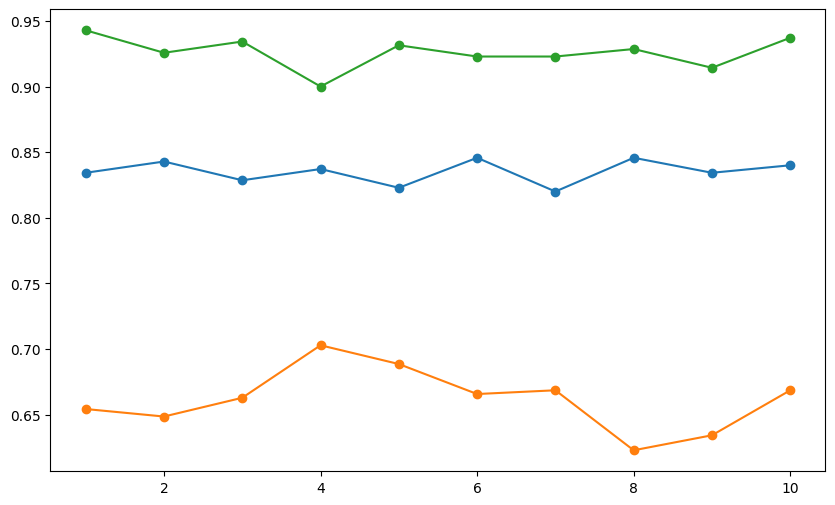

In [14]:
plt.figure(figsize=(10, 6))

for clf_name, metrics in results.items():
    plt.plot(range(1, 11), metrics['accuracy']['scores'], marker='o', label=f'{clf_name} Accuracy')



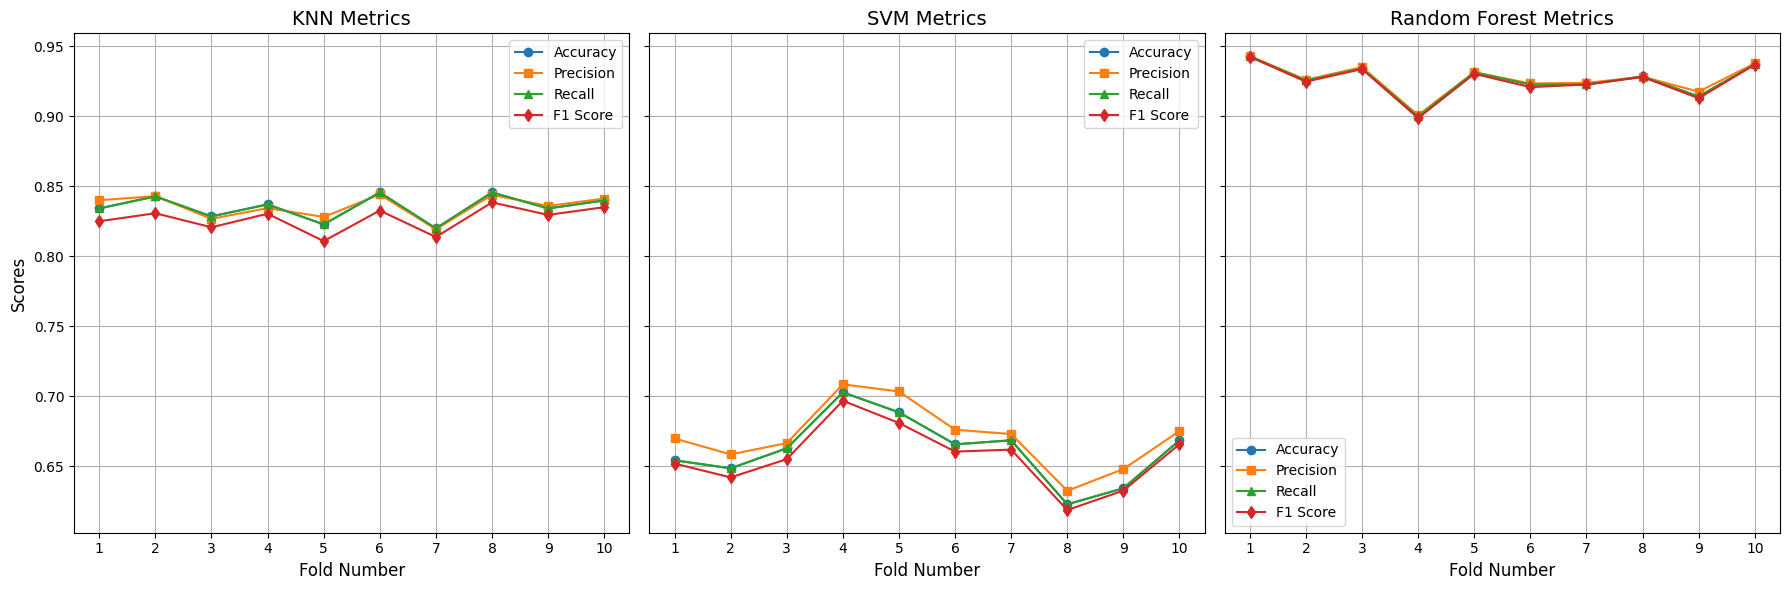

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, (clf_name, metrics) in enumerate(results.items()):
    ax = axes[idx]
    ax.plot(range(1, 11), metrics['accuracy']['scores'], marker='o', label='Accuracy')
    ax.plot(range(1, 11), metrics['precision']['scores'], marker='s', label='Precision')
    ax.plot(range(1, 11), metrics['recall']['scores'], marker='^', label='Recall')
    ax.plot(range(1, 11), metrics['f1']['scores'], marker='d', label='F1 Score')

    ax.set_title(f"{clf_name} Metrics", fontsize=14)
    ax.set_xlabel('Fold Number', fontsize=12)
    ax.set_xticks(range(1, 11))
    ax.grid(True)
    ax.legend()
    if idx == 0:
        ax.set_ylabel('Scores', fontsize=12)

plt.tight_layout()
plt.show()


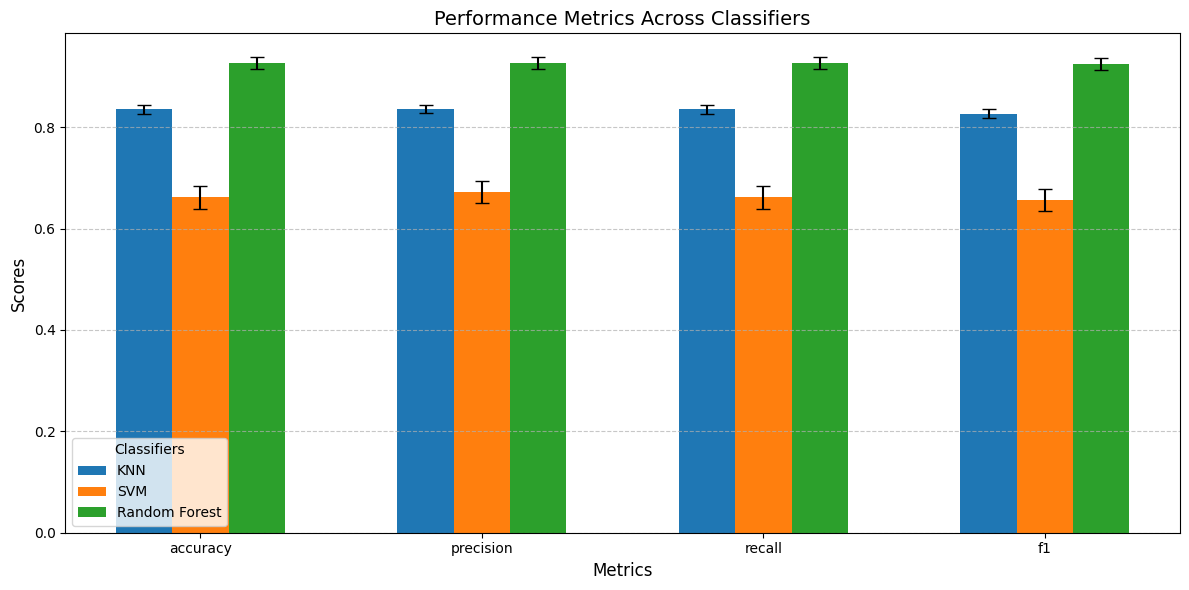

In [16]:
metrics_list = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_list))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

for idx, (clf_name, metrics) in enumerate(results.items()):
    means = [metrics[metric]['mean'] for metric in metrics_list]
    stds = [metrics[metric]['std'] for metric in metrics_list]
    ax.bar(x + idx * width, means, width, label=clf_name, yerr=stds, capsize=5)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Performance Metrics Across Classifiers', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(metrics_list, fontsize=10)
ax.legend(title="Classifiers", fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


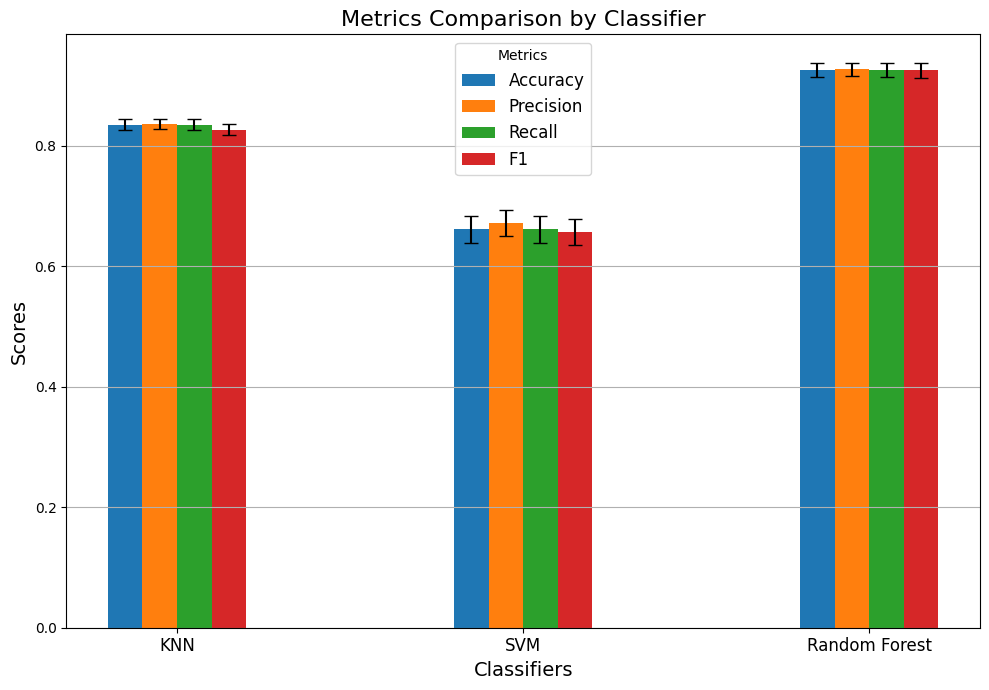

In [17]:
metrics_list = ['accuracy', 'precision', 'recall', 'f1']
classifiers_order = ['KNN', 'SVM', 'Random Forest']

x = np.arange(len(classifiers_order))
width = 0.1
metric_positions = {metric: idx for idx, metric in enumerate(metrics_list)}

fig, ax = plt.subplots(figsize=(10, 7))
for metric_name in metrics_list:
    means = [results[clf_name][metric_name]['mean'] for clf_name in classifiers_order]
    stds = [results[clf_name][metric_name]['std'] for clf_name in classifiers_order]
    metric_offset = width * metric_positions[metric_name]  # Offset for the metric bars
    ax.bar(x + metric_offset, means, width, yerr=stds, label=f"{metric_name.capitalize()}", capsize=5)
ax.set_xlabel('Classifiers', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Metrics Comparison by Classifier', fontsize=16)
ax.set_xticks(x + (len(metrics_list) - 1) * width / 2)
ax.set_xticklabels(classifiers_order, fontsize=12)
ax.legend(title="Metrics", fontsize=12)
ax.grid(axis='y')

plt.tight_layout()
plt.show()